In [1]:
import sys, yaml, h5py, random
import gc
import numpy as np
import os, glob
import time
import pyarrow as pa
import pyarrow.parquet as pq
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import *
# from dataset_loder import *
import pandas as pd
import pickle
import importlib
import mplhep as hep

In [26]:
import torch, h5py, random
from torch.utils.data import *
import pyarrow.parquet as pq


'''mass transformation function: converted to network unit'''

def transform_y(y, m0_scale):
    return y/m0_scale

def inv_transform_y(y, m0_scale):
    return y*m0_scale

'''Using mean and std z score'''
def transform_norm_y(y, mean, std):
    return (y - mean) / std

def inv_transform_norm_y(y, mean, std):
    return y * std + mean

''' data loder defination without ieta and iphi'''


class H5Dataset(Dataset):
    def __init__(self, file_path, indices):
        self.file_path = file_path
        self.indices = indices
        self.file = h5py.File(file_path, 'r')

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        index = self.indices[idx]
        data = self.file['all_jet'][index]
        am = self.file['am'][index]
        return data, am

# with lazy loadings
class H5Dataset_(Dataset):
    def __init__(self, file_path, indices ):
        self.indices = indices
        self.file_path = file_path

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        idx = self.indices[idx]
        with h5py.File(self.file_path, 'r') as file:
            data = file['all_jet'][idx]
            am = file['am'][idx]
            return data, am





# ## Efficient h5 data loading
# class ChunkedSampler(Sampler):
#     def __init__(self, data_source, chunk_size=3200, shuffle=False):
#         self.data_source = data_source
#         self.chunk_size = chunk_size
#         self.num_chunks = len(data_source) // chunk_size
#         self.indices = sorted(data_source)
#         self.shuffle = shuffle

#     def shuffle_indices(self):
#         chunk_indices = [self.indices[i * self.chunk_size:(i + 1) * self.chunk_size] for i in range(self.num_chunks)]
#         random.shuffle(chunk_indices)
#         self.indices = [idx for chunk in chunk_indices for idx in chunk]

#     def __iter__(self):
#         if self.shuffle:
#             self.shuffle_indices()
#         return iter(self.indices)

#     def __len__(self):
#         return len(self.data_source)

# class RegressionDataset(Dataset):
#     def __init__(self, h5_path, transforms=None, preload_size=3200):
#         self.h5_path = h5_path
#         self.transforms = transforms
#         self.preload_size = preload_size
#         self.h5_file = h5py.File(self.h5_path, 'r', libver='latest', swmr=True)
#         self.data = self.h5_file['all_jet']
#         self.labels = self.h5_file['am']
#         self.ieta = self.h5_file['ieta']
#         self.iphi = self.h5_file['iphi']
#         self.dataset_size = self.data.shape[0]

#         self.chunk_size = self.data.chunks

#         self.preloaded_data = None
#         self.preloaded_labels = None
#         self.preload_start = -1

#     def __len__(self):
#         return self.dataset_size

#     def __getitem__(self, idx):
#         preload_start = (idx // self.preload_size) * self.preload_size
#         if preload_start != self.preload_start:
#             self.preload_start = preload_start
#             preload_end = min(preload_start + self.preload_size, self.dataset_size)
#             self.preloaded_data = self.data[preload_start:preload_end]
#             self.preloaded_labels = self.labels[preload_start:preload_end]
#             self.preloaded_ieta = self.ieta[preload_start:preload_end]
#             self.preloaded_iphi = self.iphi[preload_start:preload_end]

#         local_idx = idx - self.preload_start
#         data = self.preloaded_data[local_idx]
#         labels = self.preloaded_labels[local_idx]
#         ieta = self.preloaded_ieta[local_idx]
#         iphi = self.preloaded_iphi[local_idx]
#         if self.transforms:
#             data = self.transforms(data)
#         return torch.from_numpy(data), torch.from_numpy(labels),torch.from_numpy(iphi),torch.from_numpy(ieta)

#     def __del__(self):
#         self.h5_file.close()


## Efficient h5 data loading
class ChunkedSampler(Sampler):
    def __init__(self, data_source, chunk_size=3200, shuffle=False):
        self.data_source = data_source
        self.chunk_size = chunk_size
        self.num_chunks = len(data_source) // chunk_size
        self.indices = sorted(data_source)
        self.shuffle = shuffle

    def shuffle_indices(self):
        chunk_indices = [self.indices[i * self.chunk_size:(i + 1) * self.chunk_size] for i in range(self.num_chunks)]
        random.shuffle(chunk_indices)
        self.indices = [idx for chunk in chunk_indices for idx in chunk]

    def __iter__(self):
        if self.shuffle:
            self.shuffle_indices()
        return iter(self.indices)

    def __len__(self):
        return len(self.data_source)

class RegressionDataset(Dataset):
    def __init__(self, h5_path, transforms=None, preload_size=3200):
        self.h5_path = h5_path
        self.transforms = transforms
        self.preload_size = preload_size
        self.h5_file = h5py.File(self.h5_path, 'r', libver='latest', swmr=True)
        self.data = self.h5_file['all_jet']
        self.labels = self.h5_file['am']
        self.ieta = self.h5_file['ieta']
        self.iphi = self.h5_file['iphi']
        self.dataset_size = self.data.shape[0]

        self.chunk_size = self.data.chunks

        self.preloaded_data = None
        self.preloaded_labels = None
        self.preload_start = -1

    def __len__(self):
        return self.dataset_size

    def __getitem__(self, idx):
        preload_start = (idx // self.preload_size) * self.preload_size
        if preload_start != self.preload_start:
            self.preload_start = preload_start
            preload_end = min(preload_start + self.preload_size, self.dataset_size)
            self.preloaded_data = self.data[preload_start:preload_end]
            self.preloaded_labels = self.labels[preload_start:preload_end]
            self.preloaded_ieta = self.ieta[preload_start:preload_end]
            self.preloaded_iphi = self.iphi[preload_start:preload_end]

        local_idx = idx - self.preload_start
        data = np.delete(self.preloaded_data[local_idx], 4, axis=0) 
        labels = self.preloaded_labels[local_idx]
        ieta = self.preloaded_ieta[local_idx]
        iphi = self.preloaded_iphi[local_idx]
        scaling_factors = np.array([0.02, 1, 2, 0.2, 1]) 
        zero_supression_min = np.array([0.001, 0.0001, 0.0001, 0.001, 0.001])
        zero_supression_max = np.array([1000, 20, 10, 500, 100])
        # Zero-suppress pixels: 
        data[:5] = np.where(np.abs(data[:5]) < zero_supression_min[:, np.newaxis, np.newaxis], 0, data[:5])
        data[:5] = np.where(np.abs(data[:5]) > zero_supression_max[:, np.newaxis, np.newaxis], 0, data[:5])
        data[:5] *= scaling_factors[:, np.newaxis, np.newaxis]  # Apply scaling to first 5 channels
        
        if self.transforms:
            data = self.transforms(data)
        return torch.from_numpy(data), torch.from_numpy(labels),torch.from_numpy(iphi),torch.from_numpy(ieta)

    def __del__(self):
        self.h5_file.close()


In [27]:
def set_random_seeds(random_seed=0):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)
    
set_random_seeds(42)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Correct way to specify GPU index
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
torch.backends.cudnn.benchmark = True



cuda:0


In [28]:
def set_scheduler(optimizer, scheduler_, mode, patience, lr_init, lr_factor):
    """ set the lr scheduler """
    if  scheduler_ == 'ReduceLROnPlateau':
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode, patience=patience, verbose=True, min_lr=lr_init, factor=lr_factor)
    elif scheduler_ == 'cosine':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=patience)
    else:
        scheduler = None
    return scheduler

def set_optimizer(optimizer_,lr_init):
    """ set the optimizer """
    if optimizer_ == 'Adam':
        optimizer = optim.Adam(resnet.parameters(), lr=lr_init)
    elif optimizer_ == 'SGD':
        optimizer = optim.SGD(resnet.parameters(), lr=lr_init, momentum=0.9)
    return optimizer
    
def mae_loss_wgtd(pred, true, wgt=1.):
    loss = wgt*(pred-true).abs().to(device)
    return loss.mean()


%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

class LivePlot:
    def __init__(self):
        self.epochs = []
        self.train_losses = []
        self.val_losses = []
        self.learning_rates = []
        self.mae_train = []
        self.mae_val = []
       

   

    def update(self, epoch, train_loss, val_loss, mae_train, mae_val, lr, m_true_, m_pred_, gradients_dict):
        self.epochs.append(epoch)
        self.train_losses.append(train_loss)
        self.val_losses.append(val_loss)
        self.mae_train.append(mae_train)
        self.mae_val.append(mae_val)
        self.learning_rates.append(lr)

        clear_output(wait=True)  # Clear previous plots

        fig, axs = plt.subplots(5, 1, figsize=(8, 8))  # 2 rows, 1 column

        # Plot Losses
        axs[0].plot(self.epochs, self.train_losses, label="Train Loss", color="blue")
        axs[0].plot(self.epochs, self.val_losses, label="Validation Loss", color="red")
        axs[0].set_xlabel("Epochs")
        axs[0].set_ylabel("Loss")
        axs[0].set_title("Training & Validation Loss")
        axs[0].legend()
        axs[0].grid(True)

        # Plot Learning Rate
        axs[1].plot(self.epochs, self.learning_rates, label="Learning Rate", color="green")
        axs[1].set_xlabel("Epochs")
        axs[1].set_ylabel("Learning Rate")
        axs[1].set_title("Learning Rate Schedule")
        axs[1].legend()
        axs[1].grid(True)

       
        axs[2].hist(m_true_, bins=np.arange(0,18.5,0.4), alpha=0.5, histtype = 'step', label="True Mass", color='blue' )
        axs[2].hist(m_pred_, bins=np.arange(0,18.5,0.4), alpha=0.5, histtype = 'step', label="Predicted Mass", color='red')
        axs[2].set_xlabel("Mass Value")
        axs[2].set_ylabel("Frequency")
        axs[2].set_title(f"Histogram of True vs Predicted Mass at Epoch {epoch}")
        axs[2].legend()

        axs[3].plot(self.epochs, self.mae_train, label="Train MAE", color="blue")
        axs[3].plot(self.epochs, self.mae_val, label="Validation MAE", color="red")
        axs[3].set_xlabel("Epochs")
        axs[3].set_ylabel("MAE")
        axs[3].set_title("Training & Validation MAE")
        axs[3].legend()
        axs[3].grid(True)

        for name, grads in gradients_dict.items():
            axs[4].plot(grads, label=name)
            axs[4].set_xlabel("Epoch")
            axs[4].set_ylabel("Mean Gradient")
            axs[4].set_title("Gradient Flow Over Training")
            # axs[4].legend()
            axs[4].set_yscale("log")
        

        plt.tight_layout()
        plt.show()
mae_best = 10000.
def do_eval(resnet, val_loader, mae_best, epoch):
    torch.cuda.empty_cache()
    loss_ = 0.
    m_pred_, m_true_, mae_, mre_, m0_ = [], [], [], [], []
    now = time.time()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            X, am = data[0].to(device), data[1].to(device)
            iphi, ieta = data[2].to(device), data[3].to(device)
            am = transform_norm_y(am, mass_mean, mass_std)
            iphi = iphi/360.
            ieta = ieta/140.
            logits = resnet([X, iphi, ieta])
            loss= mae_loss_wgtd(logits, am).item()
            loss_ += loss
            logits, am = inv_transform_norm_y(logits,mass_mean, mass_std), inv_transform_norm_y(am,mass_mean, mass_std)
            mae = (logits-am).abs()
            mre = (((logits-am).abs())/am)
            m_pred_.append(logits.detach().cpu().numpy())
            m_true_.append(am.detach().cpu().numpy())
            mae_.append(mae.detach().cpu().numpy())
            mre_.append(mre.detach().cpu().numpy())


            if i % w_iter_freq  == 0:
        

                print('Validation (%d/%d): Train loss:%f, mae:%f, mre:%f'%(i+1, len(val_loader), loss, mae.mean().item(), mre.mean().item() ))

            del logits
           
        now = time.time() - now
        m_true_ = np.concatenate(m_true_)
        m_pred_ = np.concatenate(m_pred_)
        mae_ = np.concatenate( mae_)
        mre_ = np.concatenate(mre_)
        

        output_dict = {}
        output_dict["m_true"] = m_true_
        output_dict["m_pred"] = m_pred_
        



        print('%d: Val loss:%f, mae:%f, mre:%f'%(epoch, loss_/len(val_loader), np.mean(mae_), np.mean(mre_)))
        valid_dir = f'{out_dir}/valid_data'
        os.makedirs(valid_dir, exist_ok=True)
        with open(f'{valid_dir}/epoch_{epoch}_inference_data.pkl', "wb") as outfile:
              pickle.dump(output_dict, outfile, protocol=2) #protocol=2 for compatibility


        return loss_/len(val_loader), np.mean(mae_), m_true_, m_pred_


In [29]:

class ResBlock_LiR(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(ResBlock_LiR, self).__init__()
        self.downsample = out_channels//in_channels
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=self.downsample, padding=1)
        self.leaky_relu = nn.LeakyReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=self.downsample)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.leaky_relu(out)
        out = self.conv2(out)
        if self.downsample > 1:
            residual = self.shortcut(x)
        out += residual
        out = self.leaky_relu(out)
        return out


class ResNet_LiR(nn.Module):

    def __init__(self, in_channels, nblocks, fmaps):
        super(ResNet_LiR, self).__init__()
        self.fmaps = fmaps
        self.nblocks = nblocks
        self.conv0 = nn.Conv2d(in_channels, fmaps[0], kernel_size=7, stride=1, padding=1)
        self.layer1 = self.block_layers(self.nblocks, [fmaps[0],fmaps[0]])
        self.layer2 = self.block_layers(1, [fmaps[0],fmaps[1]])
        self.layer3 = self.block_layers(self.nblocks, [fmaps[1],fmaps[1]])
        self.layer4 = self.block_layers(1, [fmaps[1],fmaps[2]])
        self.layer5 = self.block_layers(self.nblocks, [fmaps[2],fmaps[2]])
        self.layer6 = self.block_layers(1, [fmaps[2],fmaps[3]])
        self.layer7 = self.block_layers(self.nblocks, [fmaps[3],fmaps[3]])
        self.fc = nn.Linear(self.fmaps[3]+2, 1)
        self.GlobalMaxPool2d = nn.AdaptiveMaxPool2d((1,1))

    def block_layers(self, nblocks, fmaps):
        layers = []
        for _ in range(nblocks):
            layers.append(ResBlock_LiR(fmaps[0], fmaps[1]))
        return nn.Sequential(*layers)

    def forward(self, X):
        x = self.conv0(X[0])
        x = F.leaky_relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.GlobalMaxPool2d(x)
        x = x.view(x.size()[0], self.fmaps[3])
        x = torch.cat([x, X[1], X[2]], 1)
        x = self.fc(x)
        return x
# model = ResNet_LiR(in_channels=13, nblocks=3, fmaps=[8,16,32,64])

In [30]:

load_epoch= 0
epochs= 5
lr_init= 1e-3
lr_factor= .1
new_lr= 1e-3
reslayers= [8,16,32,64]
resblocks= 3
channels= [0,1,2,3,4,5,6,7,8,9,10,11,12] 
loss_func= 'mse'
scheduler_= 'cosine'
optimizer_= 'Adam'
patience= 2
scheduler_mode= 'min'

BATCH_SIZE= 1024
VAL_BATCH_SIZE= 128
TEST_BATCH_SIZE= 128
indices= [0,1,2,3,4,5,6,7,8,9,10,11,12] 


n_train= 4000
n_valid= 2000
n_test= 40


mass_mean= 9.025205 
mass_std= 5.1880417




random_seed=42
w_iter_freq=50
num_data_workers= 4


# train_dir= "/pscratch/sd/b/bbbam/IMG_aToTauTau_Hadronic_with_Tau_decay_m0To18_pt30T0300_normalized_unbiased_combined_h5/IMG_aToTauTau_Hadronic_with_Tau_decay_m0To18_pt30T0300_original_unbiased_combined_train_normalized.h5"
# valid_dir= "/pscratch/sd/b/bbbam/IMG_aToTauTau_Hadronic_with_Tau_decay_m0To18_pt30T0300_normalized_unbiased_combined_h5/IMG_aToTauTau_Hadronic_with_Tau_decay_m0To18_pt30T0300_original_unbiased_combined_valid_normalized.h5"
train_dir= "/pscratch/sd/b/bbbam/IMG_aToTauTau_m1p2T018_combined_normalized_h5/IMG_aToTauTau_Hadronic_m1p2To18_pt30T0300_unbiased_train_normalized.h5"
valid_dir= "/pscratch/sd/b/bbbam/IMG_aToTauTau_m1p2T018_combined_normalized_h5/IMG_aToTauTau_Hadronic_m1p2To18_pt30T0300_unbiased_valid_normalized.h5"
out_dir = '/pscratch/sd/b/bbbam/jupyter_notebook'

channel_list = ["Tracks_pt", "Tracks_dZSig", "Tracks_d0Sig", "ECAL_energy","HBHE_energy", "Pix_1", "Pix_2", "Pix_3", "Pix_4", "Tib_1", "Tib_2" ,"Tob_1", "Tob_2"]


channels_used = [channel_list[ch] for ch in indices]
layers_names = ' | '.join(channels_used)
print("channels used : ", layers_names)



file_train = glob.glob(f'{train_dir}')[0]
file_valid = glob.glob(f'{valid_dir}')[0]

train_dset = RegressionDataset(file_train, preload_size=32)
valid_dset = RegressionDataset(file_valid, preload_size=32)
n_total_train = len(train_dset)
n_total_valid = len(valid_dset)


if n_train != -1:
    train_indices = list(range(n_train))
    random.shuffle(train_indices)
else:
    train_indices = list(range(n_total_train))
    random.shuffle(train_indices)

if n_valid !=-1:
    valid_indices = list(range(n_valid))
    random.shuffle(valid_indices)
else:
    valid_indices = list(range(n_total_valid))
    random.shuffle(valid_indices)

n_train = len(train_indices)
n_val = len(valid_indices)
print(f"Total train sample : {n_total_train} only used: {n_train} ---> {n_train/n_total_train*100} %")

print(f"Total valid sample : {n_total_valid} only used: {n_valid} ---> {n_valid/n_total_valid*100} %")

train_sampler = ChunkedSampler(train_indices, chunk_size=BATCH_SIZE, shuffle=True)
train_loader = DataLoader(train_dset, batch_size=BATCH_SIZE, sampler=train_sampler, pin_memory=True, num_workers=num_data_workers)

val_sampler = ChunkedSampler(valid_indices, chunk_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(valid_dset, batch_size=BATCH_SIZE, sampler=val_sampler, pin_memory=True, num_workers=num_data_workers)


import torch_resnet_concat as networks
resnet = networks.ResNet(len(indices)-1, resblocks, reslayers)
# resnet = ResNet_LiR(12, resblocks, reslayers)
resnet=resnet.to(device)
optimizer = set_optimizer(optimizer_,lr_init)
scheduler = set_scheduler(optimizer, scheduler_, scheduler_mode, patience, lr_init, lr_factor)

channels used :  Tracks_pt | Tracks_dZSig | Tracks_d0Sig | ECAL_energy | HBHE_energy | Pix_1 | Pix_2 | Pix_3 | Pix_4 | Tib_1 | Tib_2 | Tob_1 | Tob_2
Total train sample : 4063011 only used: 4000 ---> 0.09844915507243274 %
Total valid sample : 448577 only used: 2000 ---> 0.44585433493023496 %


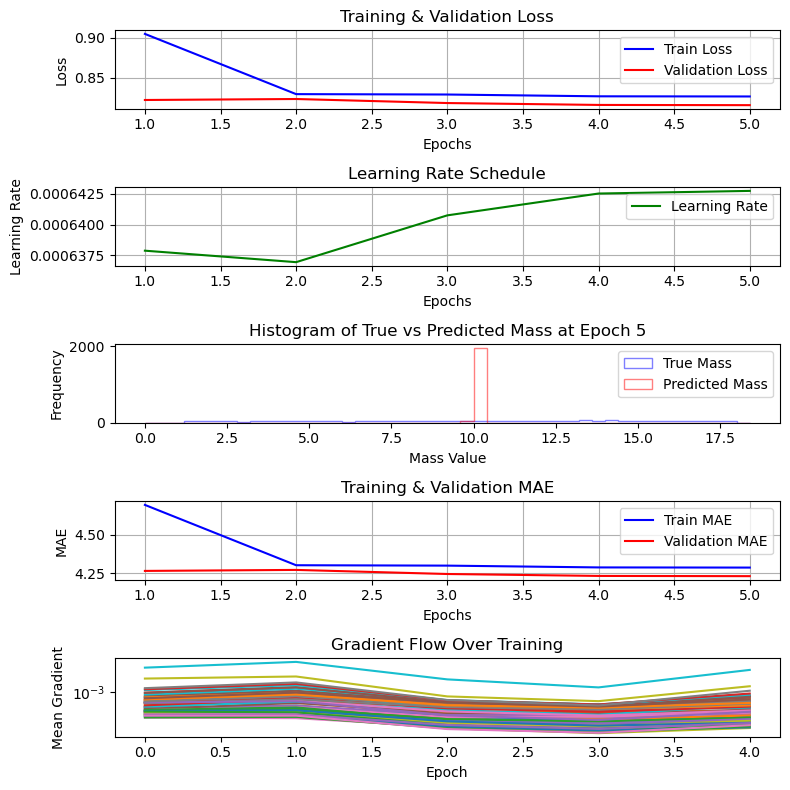

-----------------complete training-----------------


In [31]:

plotter = LivePlot()
gradients_dict = {}
gradients_dict_ave = {}
def log_gradients_ave(epoch):
    for name, param in resnet.named_parameters():
        if param.grad is not None:
            if name not in gradients_dict:
                gradients_dict_ave[name] = []
            gradients_dict_ave[name].append(param.grad.abs().mean().item())


def log_gradients(epoch, model):
    for name, param in model.named_parameters():
        if param.grad is not None:
            if name not in gradients_dict:
                gradients_dict[name] = []
            gradients_dict[name].append(param.grad.clone().cpu())
            
for e in range(epochs):
    loss_t = 0.
    mae_t = 0.
    mre_t =0.
    epoch = e+1+load_epoch
    epoch_wgt = 0.
    n_trained = 0
    print('>> Epoch %d <<<<<<<<'%(epoch))

    # Run training
    m_true_, m_pred_ = [], []
    resnet.train()
    now = time.time()
    for i, data in enumerate(train_loader):
        X, am = data[0].to(device), data[1].to(device)
        iphi, ieta = data[2].to(device), data[3].to(device)

        with torch.no_grad():
            # am = transform_y(am, m0_scale)
            am = transform_norm_y(am, mass_mean, mass_std)
            iphi = iphi/360.
            ieta = ieta/140.

        optimizer.zero_grad()
        logits = resnet([X, iphi, ieta])
        loss = mae_loss_wgtd(logits, am)
        loss.backward()
        

        
        # for name, param in resnet.named_parameters():
        #     if param.grad is not None:
        #         print(f"{name}: {param.grad.abs().mean().item()}")
        # Find the first convolution layer inside resnet
        # print("Before update:", resnet.layer1[0].conv1.weight[0, 0, :, :])  
        # optimizer.step()
        # print("After update:", resnet.layer1[0].conv1.weight[0, 0, :, :])  

        # torch.nn.utils.clip_grad_norm_(resnet.parameters(), max_norm=1.0)

        optimizer.step()
        epoch_wgt += len(am)
        loss_t += loss.item()
        n_trained += 1
        logits, am = inv_transform_norm_y(logits, mass_mean, mass_std), inv_transform_norm_y(am, mass_mean, mass_std)
        mae =  (logits-am).abs().mean()
        mre = (((logits-am).abs())/am).mean()
        mae_t += mae.item()
        mre_t += mre.item()
    
        if i % w_iter_freq  == 0:
            print('%d: (%d/%d) Train loss:%f, mae:%f, mre:%f'%(epoch, i+1, len(train_loader), loss.item(), mae.item(), mre.item() ))
            

    now = time.time() - now
    # print('%d: Train time:%.2fs in %d steps for N:%d, wgt: %.f'%(epoch, now, len(train_loader), n_trained, epoch_wgt))
    print('%d: Train loss:%f, mae:%f, mre:%f'%(epoch, loss_t/(i+1), mae_t/(i+1), mre_t/(i+1) ))
    log_gradients_ave(epoch)
    log_gradients(epoch, resnet)
    model_dir = f'{out_dir}/Model'
    filename  = f'{model_dir}/model_epoch_{epoch}.pkl'
    os.makedirs(model_dir, exist_ok=True)
    model_dict = {'model_state_dict': resnet.state_dict(), 'optimizer_state_dict': optimizer.state_dict(), 'scheduler_state_dict': scheduler.state_dict(), 'epoch' : epoch}
    torch.save(model_dict, filename)

    # Run Validation
    resnet.eval()
    val_loss, mae_val, m_true_, m_pred_ = do_eval(resnet, val_loader, mae_best, epoch)
    scheduler.step(val_loss)
    curr_lr = scheduler._last_lr[0]
    print("current learning rate: ", curr_lr)
    plotter.update(epoch, loss_t/(i+1), val_loss, mae_t/(i+1), mae_val, curr_lr, m_true_, m_pred_, gradients_dict_ave)
print("-----------------complete training-----------------")

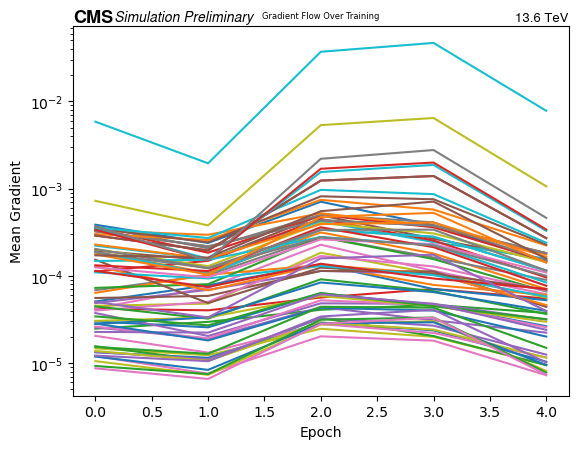

In [12]:
# Plot Gradients Per Layer
fig, ax = plt.subplots()
for name, grads in gradients_dict_ave.items():
    plt.plot(grads, label=name)
plt.xlabel("Epoch")
plt.ylabel("Mean Gradient")
plt.title("Gradient Flow Over Training", size = 6)
# plt.legend()
hep.cms.label(llabel="Simulation Preliminary", rlabel="13.6 TeV", loc=0, ax=ax)
plt.yscale("log")
plt.show()

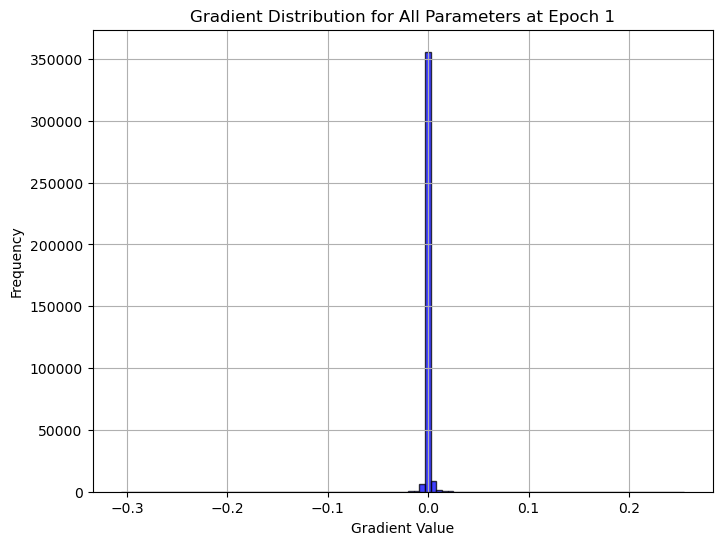

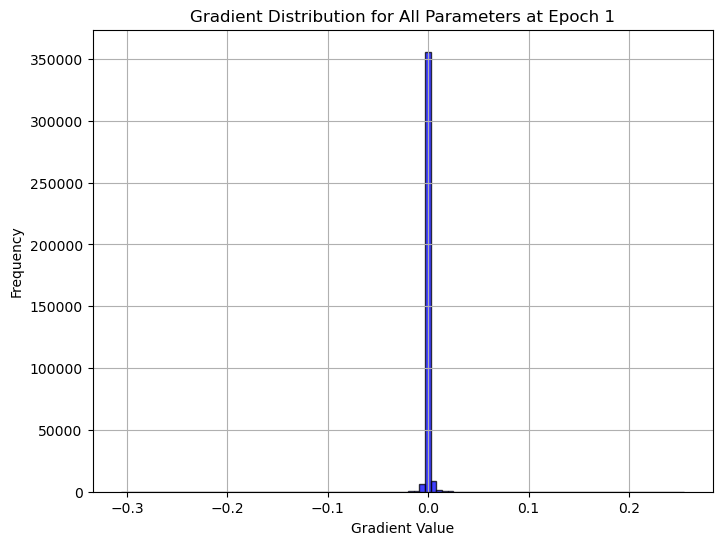

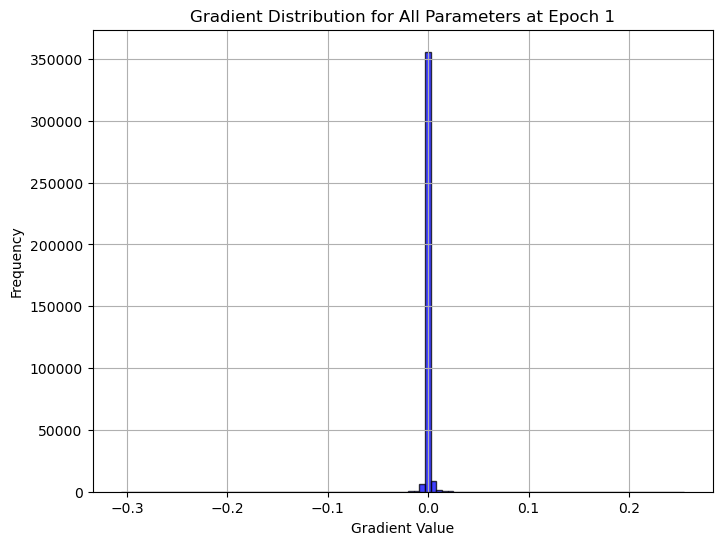

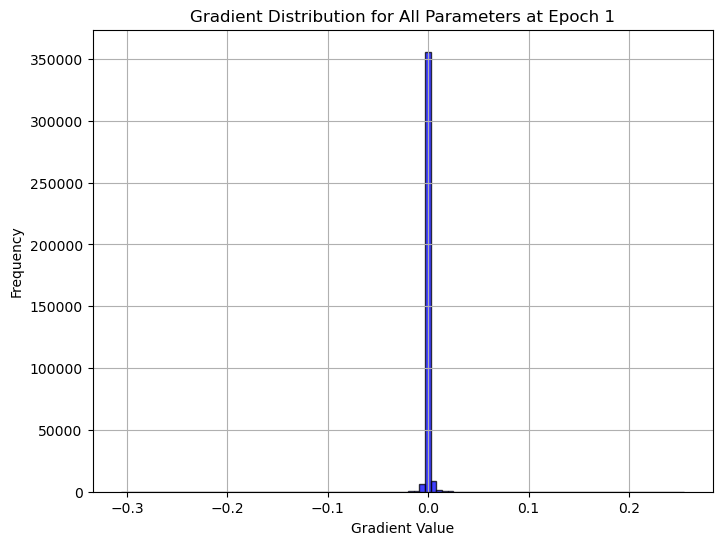

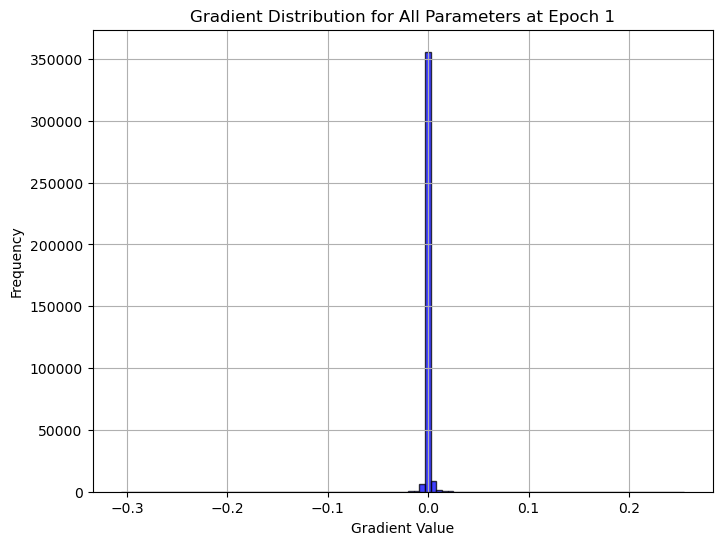

In [54]:
# Plot Gradients distribution
def plot_all_gradients_distribution(epoch):
    all_gradients = []

    for param_name, gradients in gradients_dict.items():
        if epoch < len(gradients):
            all_gradients.extend(gradients[epoch].flatten().numpy())  # Flatten and collect gradients

    if all_gradients:
        plt.figure(figsize=(8, 6))
        plt.hist(all_gradients, bins=100, alpha=0.75, color='blue', edgecolor='black')
        plt.xlabel("Gradient Value")
        plt.ylabel("Frequency")
        plt.title(f"Gradient Distribution for All Parameters at Epoch {epoch}")
        plt.grid(True)
        plt.show()
    else:
        print(f"No gradients found for epoch {epoch}.")

# Example Usage:
for epoch in range(5):
    plot_all_gradients_distribution(epoch=1)  # Change the epoch as needed


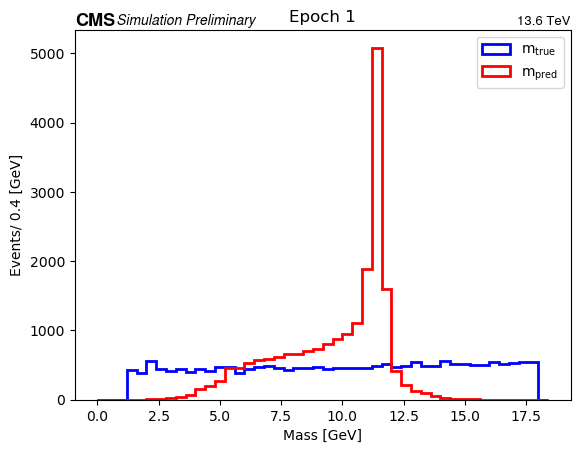

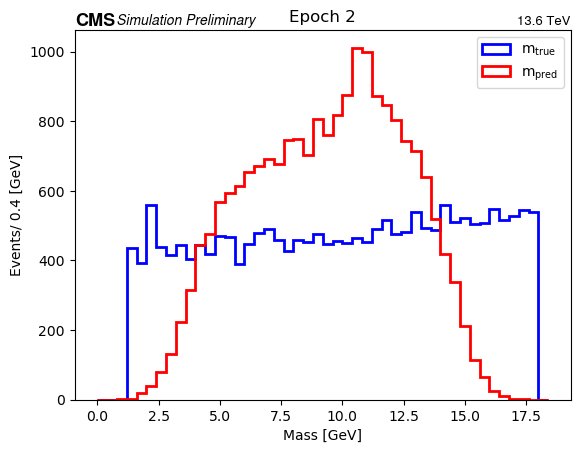

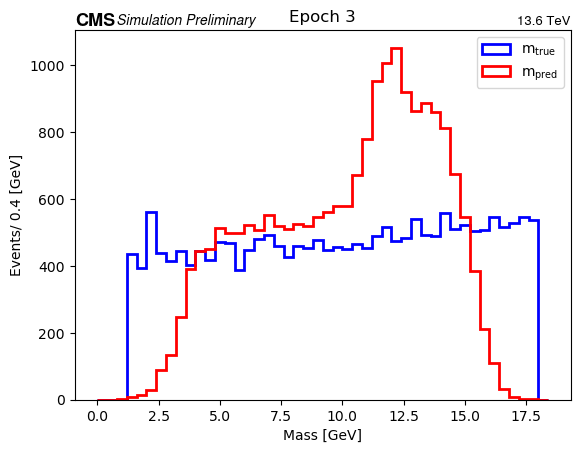

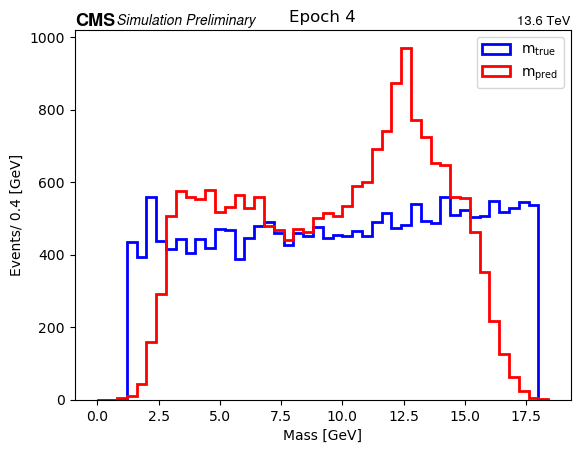

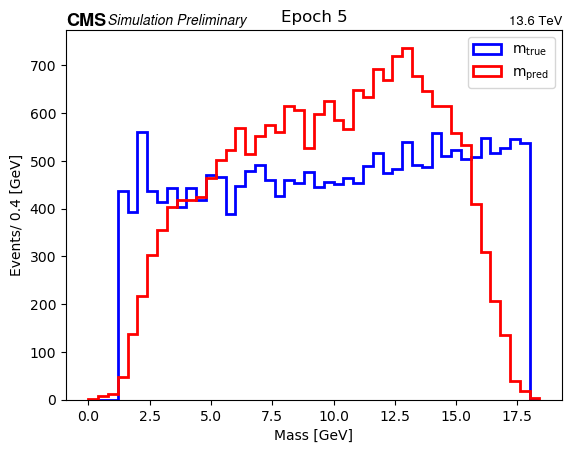

In [55]:
rhFileList = '%s/valid_data/*.pkl'%(out_dir)
paths = np.sort(glob.glob(rhFileList))
assert len(paths) > 0
for index, data_file in enumerate(paths):
    infile = open(f"{data_file}", "rb")
    data = pickle.load(infile)
    
    infile.close()
    
    m_true_ = data["m_true"]
    m_pred_ = data["m_pred"]
    
    m0_min = 0
    m0_max = 18.5
    bin_size =0.4
    fig, ax = plt.subplots()
    plt.hist(m_true_,  bins=np.arange(m0_min,m0_max,bin_size), histtype='step', label=r'$\mathrm{m_{true}}$', linestyle='-', color='blue', linewidth=2)
    plt.hist(m_pred_, bins=np.arange(m0_min,m0_max,bin_size), histtype='step', label=r'$\mathrm{m_{pred}}$', linestyle='-', color='red', linewidth=2)
    plt.title(f"Epoch {index+1}")
    plt.xlabel('Mass [GeV]')
    plt.ylabel('Events/ 0.4 [GeV]')
    plt.legend(loc='upper right')
    hep.cms.label(llabel="Simulation Preliminary", rlabel="13.6 TeV", loc=0, ax=ax)
    plt.show()

Total test sample : 267 only used: 267 ---> 100.0 %
Validation (1/20): Train loss:0.707790, mae:3.672043, mre:0.992444
4: Val loss:0.035389, mae:3.672043, mre:0.992444


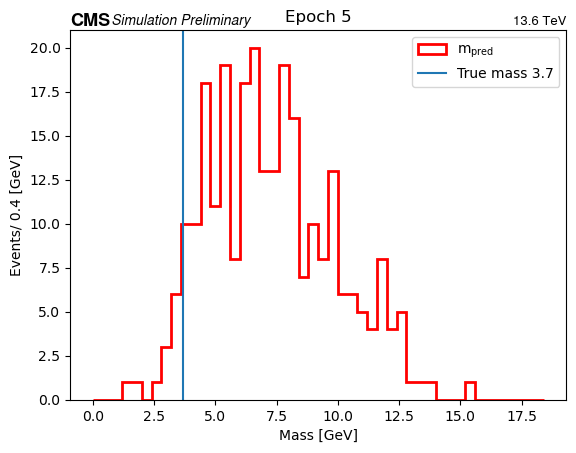

Total test sample : 962 only used: 267 ---> 27.754677754677754 %
Validation (1/20): Train loss:0.680219, mae:3.529005, mre:0.252072
4: Val loss:0.034011, mae:3.529005, mre:0.252072


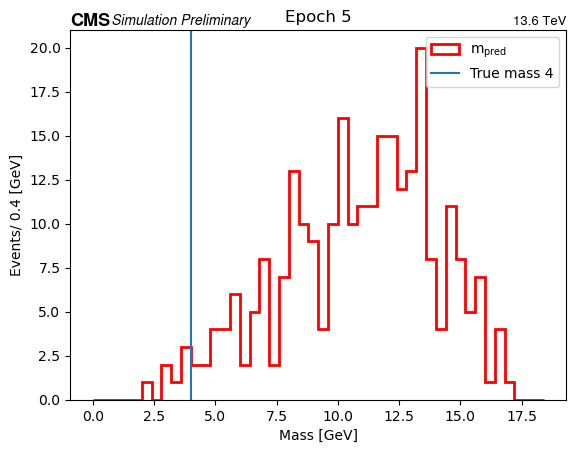

Total test sample : 6930 only used: 267 ---> 3.852813852813853 %
Validation (1/20): Train loss:0.748280, mae:3.882107, mre:0.647017
4: Val loss:0.037414, mae:3.882107, mre:0.647017


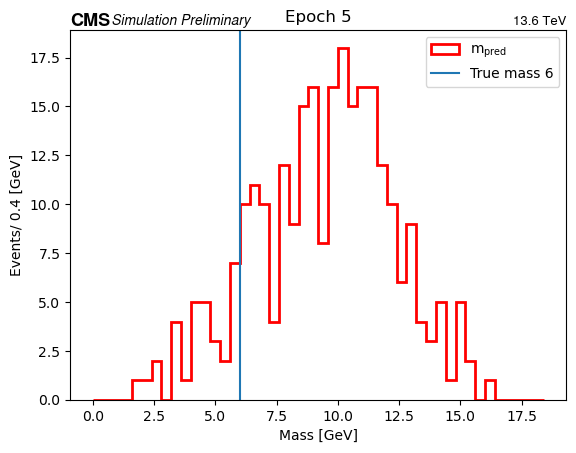

Total test sample : 962 only used: 267 ---> 27.754677754677754 %
Validation (1/20): Train loss:0.680219, mae:3.529005, mre:0.252072
4: Val loss:0.034011, mae:3.529005, mre:0.252072


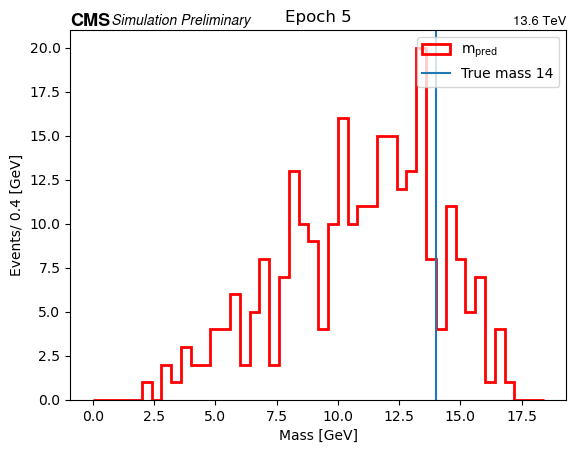

In [56]:
n_test = -1
load_epoch = epoch


Masses =['3p7', '4', '6', '14']
for Mass in Masses:

    m_true = {'3p7':3.7, '4':4, '6':6, '14':14}.get(Mass, None)
    # test_dir = glob.glob(f'/pscratch/sd/b/bbbam/signals_using_trigger_from_ruchi_combined_normalized_Tau_decay/*{Mass}*.h5')[0]
    
    test_dir = glob.glob(f'/pscratch/sd/b/bbbam/run_3_with_trigger_signals_normalized_combined/*{Mass}*.h5')[0]
    
    # print(test_dir)
    
    
    test_dset = RegressionDataset(test_dir, preload_size=32)
    n_total_test = len(test_dset)
    
    
    
    
    if n_test !=-1:
        test_indices = list(range(n_test))
        random.shuffle(test_indices)
    else:
        test_indices = list(range(n_total_test))
        random.shuffle(test_indices)
    
    n_test = len(test_indices)
    
    print(f"Total test sample : {n_total_test} only used: {n_test} ---> {n_test/n_total_test*100} %")
    
    
    test_sampler = ChunkedSampler(test_indices, chunk_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dset, batch_size=BATCH_SIZE, sampler=test_sampler, pin_memory=True, num_workers=num_data_workers)

    
    
    # load_model = glob.glob(f'{out_dir}/Model/model_epoch_{load_epoch}*')[0]#loading  model mannually
    # print('Loading weights from %s'%load_model)
    # checkpoint = torch.load(load_model)
    # resnet.load_state_dict(checkpoint['model_state_dict'])
    
    
    
    
    with torch.no_grad():
        m_pred_, m_true_, mae_, mre_, m0_ = [], [], [], [], []
        loss_ =0
        for i, data in enumerate(test_loader):
            X, am = data[0].to(device), data[1].to(device)
            iphi, ieta = data[2].to(device), data[3].to(device)
            am = transform_norm_y(am, mass_mean, mass_std)
            iphi = iphi/360.
            ieta = ieta/140.
            logits = resnet([X, iphi, ieta])
            loss= mae_loss_wgtd(logits, am).item()
            loss_ += loss
            logits, am = inv_transform_norm_y(logits,mass_mean, mass_std), inv_transform_norm_y(am,mass_mean, mass_std)
            mae = (logits-am).abs()
            mre = (((logits-am).abs())/am)
            m_pred_.append(logits.detach().cpu().numpy())
            m_true_.append(am.detach().cpu().numpy())
            mae_.append(mae.detach().cpu().numpy())
            mre_.append(mre.detach().cpu().numpy())
    
    
            if i % w_iter_freq  == 0:
        
    
                print('Validation (%d/%d): Train loss:%f, mae:%f, mre:%f'%(i+1, len(val_loader), loss, mae.mean().item(), mre.mean().item() ))
    
            del logits
           
        now = time.time() - now
        m_true_ = np.concatenate(m_true_)
        m_pred_ = np.concatenate(m_pred_)
        mae_ = np.concatenate( mae_)
        mre_ = np.concatenate(mre_)
        
    
        output_dict = {}
        output_dict["m_true"] = m_true_
        output_dict["m_pred"] = m_pred_
        
    
    
    
        print('%d: Val loss:%f, mae:%f, mre:%f'%(epoch, loss_/len(val_loader), np.mean(mae_), np.mean(mre_)))
    
        os.makedirs('test_data', exist_ok=True)
        with open(f'test_data/epoch_{epoch}_inference_data.pkl', "wb") as outfile:
              pickle.dump(output_dict, outfile, protocol=2) #protocol=2 for compatibility
        
        m0_min = 0
        m0_max = 18.5
        bin_size =0.4
        fig, ax = plt.subplots()
        plt.hist(m_pred_, bins=np.arange(m0_min,m0_max,bin_size), histtype='step', label=r'$\mathrm{m_{pred}}$', linestyle='-', color='red', linewidth=2)
        plt.axvline(x = m_true, label= f'True mass {m_true}' )
        plt.title(f"Epoch {index+1}")
        plt.xlabel('Mass [GeV]')
        plt.ylabel('Events/ 0.4 [GeV]')
        plt.legend(loc='upper right')
        hep.cms.label(llabel="Simulation Preliminary", rlabel="13.6 TeV", loc=0, ax=ax)
        plt.show()